# 09.2g: Dyadic Structure Analysis

**Test the dyadic hypothesis: Are componentwise differences powers-of-2 multiples of ε?**

## The Discovery

From 09.2f, BH #0 and BH #1 differ in 9 dimensions with differences at **exact powers of 2**:

| Dimension | Difference |
|-----------|------------|
| 1403      | 2.0ε       |
| 322       | 1.0ε       |
| 1487      | 0.25ε = ε/4 |
| 2479      | 0.25ε = ε/4 |
| 1155      | 0.125ε = ε/8 |
| 2012      | 0.125ε = ε/8 |
| 450       | 0.0312ε ≈ ε/32 |
| 1149      | 0.0078ε ≈ ε/128 |
| 1382      | 0.0020ε ≈ ε/512 |

## The Hypothesis

**Dyadic quantization:** Each componentwise difference is a power-of-2 multiple of ε:

$$\Delta_d = \varepsilon \cdot 2^{k_d}$$

for integer $k_d$ (possibly negative).

Then the L1 distance is:

$$d_1 = \sum_{d=1}^{2560} |\Delta_d| = \varepsilon \sum_{d=1}^{2560} 2^{k_d}$$

This is **NOT** $n \times \varepsilon$ for integer $n$, but a sum of dyadic rationals.

## What We'll Test

**Evidence FOR dyadic structure:**
1. Componentwise differences cluster at powers of 2 when normalized by ε
2. Histogram of $\log_2(|\Delta_d| / \varepsilon)$ shows peaks at integers
3. L1 distances are sums of dyadic fractions (clean binary representations)

**Evidence AGAINST:**
- Continuous distribution with no structure
- No clustering at power-of-2 values

## Interpretation

If true, this suggests:
- **Binary floating-point quantization** at bfloat16 precision
- Each dimension independently quantized to dyadic grid
- Training dynamics preserve/create power-of-2 structure

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
CLUSTER_FILE = "dense_cluster.safetensors"
CLUSTER_VECTORS_KEY = "vectors"
CLUSTER_TOKEN_IDS_KEY = "token_ids"

# Analysis parameters
LOG2_TOLERANCE = 0.1  # How close to integer for log2 values?
N_BINS = 100

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading dense cluster...")
cluster_data = load_file(data_dir / CLUSTER_FILE)
vectors = cluster_data[CLUSTER_VECTORS_KEY]
token_ids = cluster_data[CLUSTER_TOKEN_IDS_KEY]

n_vectors = len(vectors)
d = vectors.shape[1]

print(f"  Cluster size: {n_vectors:,} vectors")
print(f"  Dimensions:   {d:,}")
print()

print("✓ Data loaded")

Loading dense cluster...
  Cluster size: 124 vectors
  Dimensions:   2,560

✓ Data loaded


## Compute ε

In [4]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

# Typical magnitude in cluster
typical_magnitude = vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

print(f"Distinguishability threshold:\n")
print(f"  Typical component magnitude: {typical_magnitude:.6e}")
print(f"  ULP at this scale:           {ulp:.6e}")
print(f"  ε (2×ULP):                   {epsilon:.6e}")
print()
print("✓ ε computed")

Distinguishability threshold:

  Typical component magnitude: 2.361155e-03
  ULP at this scale:           1.525879e-05
  ε (2×ULP):                   3.051758e-05

✓ ε computed


## Compute All Componentwise Differences

In [5]:
print(f"Computing all componentwise differences...\n")
print(f"  {n_vectors:,} vectors → {n_vectors * (n_vectors - 1) // 2:,} unique pairs")
print(f"  Each pair has {d:,} componentwise differences")
print(f"  Total: {n_vectors * (n_vectors - 1) // 2 * d:,} difference values")
print()

# We'll collect all nonzero componentwise differences
# To avoid memory issues, process in batches

all_diffs = []
ZERO_THRESHOLD = 1e-10

print("Processing pairs...")
for i in range(n_vectors):
    for j in range(i + 1, n_vectors):
        diffs = torch.abs(vectors[i] - vectors[j])
        nonzero_diffs = diffs[diffs > ZERO_THRESHOLD]
        if len(nonzero_diffs) > 0:
            all_diffs.append(nonzero_diffs)

# Concatenate all differences
all_diffs = torch.cat(all_diffs)

print(f"\nCollected {len(all_diffs):,} nonzero componentwise differences")
print(f"  (Out of {n_vectors * (n_vectors - 1) // 2 * d:,} total)")
print(f"  Sparsity: {100 * (1 - len(all_diffs) / (n_vectors * (n_vectors - 1) // 2 * d)):.2f}% are zero")
print()
print("✓ Componentwise differences computed")

Computing all componentwise differences...

  124 vectors → 7,626 unique pairs
  Each pair has 2,560 componentwise differences
  Total: 19,522,560 difference values

Processing pairs...

Collected 3,446,649 nonzero componentwise differences
  (Out of 19,522,560 total)
  Sparsity: 82.35% are zero

✓ Componentwise differences computed


## Normalize and Take Log2

In [6]:
print("Normalizing by ε and taking log2...\n")

# Normalize by ε
diffs_normalized = all_diffs / epsilon

# Take log2
log2_diffs = torch.log2(diffs_normalized)

print(f"Log2(diff/ε) statistics:")
print(f"  Min:    {log2_diffs.min().item():.2f}")
print(f"  Max:    {log2_diffs.max().item():.2f}")
print(f"  Mean:   {log2_diffs.mean().item():.2f}")
print(f"  Median: {log2_diffs.median().item():.2f}")
print()

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("Percentiles:")
for p in percentiles:
    val = torch.quantile(log2_diffs, p / 100.0).item()
    print(f"  {p:2d}%: {val:6.2f}")
print()

print("✓ Log2 transformation complete")

Normalizing by ε and taking log2...

Log2(diff/ε) statistics:
  Min:    -13.00
  Max:    1.00
  Mean:   -1.88
  Median: -2.00

Percentiles:
   1%:  -6.00


   5%:  -4.19
  10%:  -4.00
  25%:  -3.00
  50%:  -2.00


  75%:  -1.00
  90%:   0.00
  95%:   0.00
  99%:   0.00

✓ Log2 transformation complete


## Dyadic Hypothesis: Histogram of log2(diff/ε)

If differences are powers of 2, we should see **sharp peaks at integer values**.

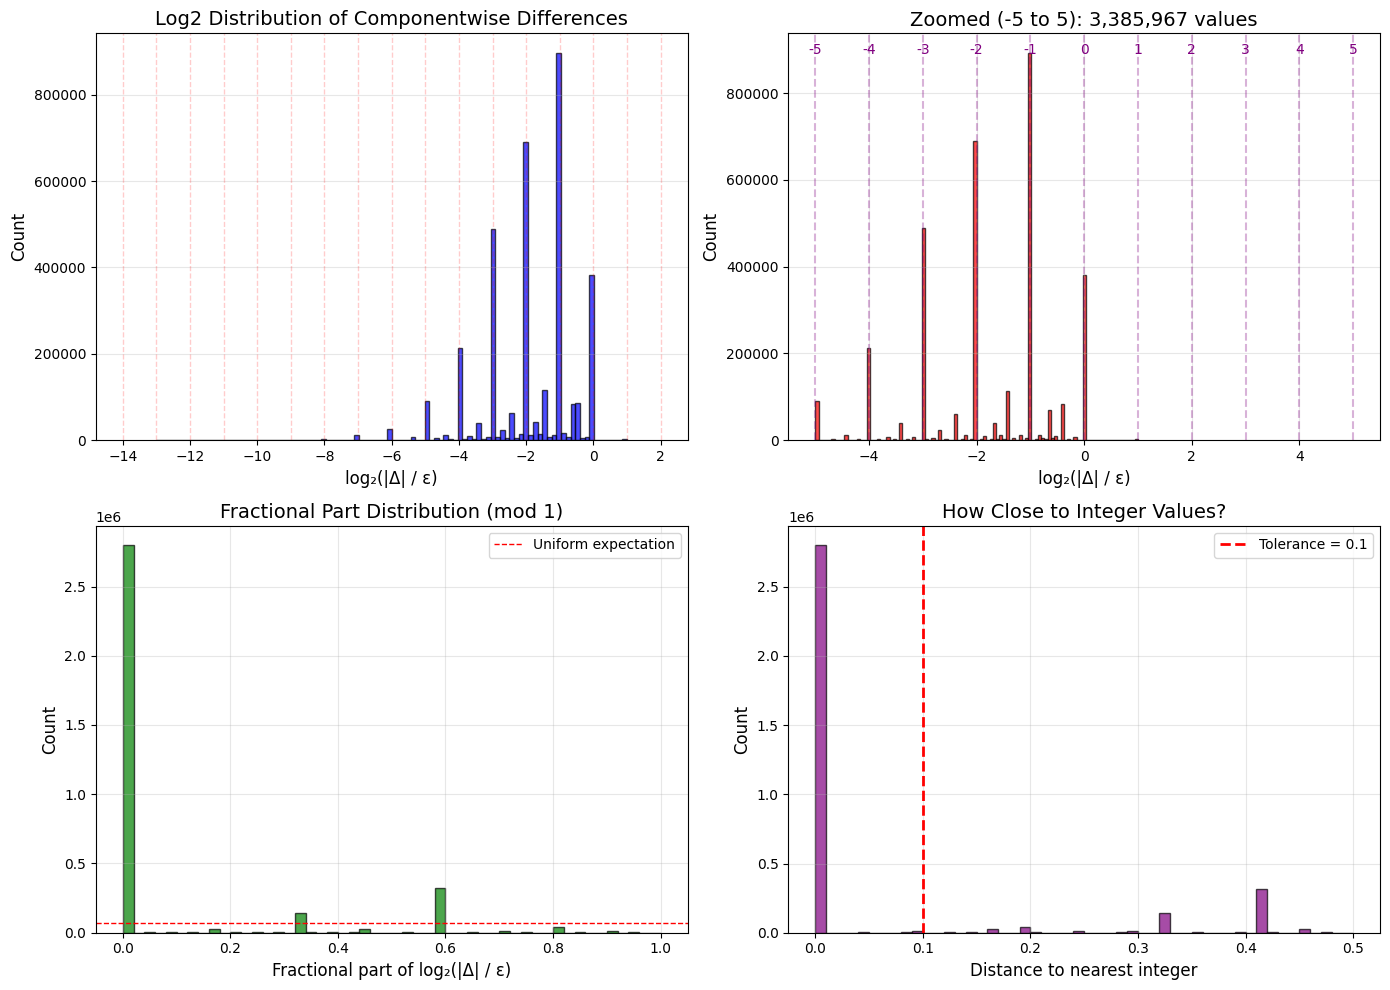

✓ Dyadic hypothesis visualization complete


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

log2_np = log2_diffs.cpu().numpy()

# Panel 1: Full distribution
ax = axes[0, 0]
ax.hist(log2_np, bins=N_BINS, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('log₂(|Δ| / ε)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Log2 Distribution of Componentwise Differences', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Mark integer values
for i in range(int(log2_np.min()) - 1, int(log2_np.max()) + 2):
    ax.axvline(i, color='red', alpha=0.2, linestyle='--', linewidth=1)

# Panel 2: Zoomed on -5 to 5
ax = axes[0, 1]
zoomed_range = log2_np[(log2_np >= -5) & (log2_np <= 5)]
if len(zoomed_range) > 0:
    ax.hist(zoomed_range, bins=100, alpha=0.7, color='red', edgecolor='black')
    ax.set_xlabel('log₂(|Δ| / ε)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Zoomed (-5 to 5): {len(zoomed_range):,} values', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Mark integer values
    for i in range(-5, 6):
        ax.axvline(i, color='purple', alpha=0.3, linestyle='--', linewidth=1.5)
        ax.text(i, ax.get_ylim()[1] * 0.95, str(i), ha='center', fontsize=10, color='purple')
else:
    ax.text(0.5, 0.5, 'No values in range', ha='center', va='center', transform=ax.transAxes)

# Panel 3: Fractional part (mod 1)
ax = axes[1, 0]
fractional_parts = log2_np - np.floor(log2_np)
ax.hist(fractional_parts, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel('Fractional part of log₂(|Δ| / ε)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Fractional Part Distribution (mod 1)', fontsize=14)
ax.axhline(len(fractional_parts) / 50, color='red', linestyle='--', linewidth=1,
           label='Uniform expectation')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 4: Distance to nearest integer
ax = axes[1, 1]
nearest_integers = np.round(log2_np)
distances_to_int = np.abs(log2_np - nearest_integers)
ax.hist(distances_to_int, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.set_xlabel('Distance to nearest integer', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('How Close to Integer Values?', fontsize=14)
ax.axvline(LOG2_TOLERANCE, color='red', linestyle='--', linewidth=2,
           label=f'Tolerance = {LOG2_TOLERANCE}')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Dyadic hypothesis visualization complete")

## Quantization Test: How Many Are Near Integer Powers of 2?

In [8]:
print("Testing dyadic quantization hypothesis...\n")

# Compute distance to nearest integer
nearest_integers = torch.round(log2_diffs)
deviations = torch.abs(log2_diffs - nearest_integers)

# Count how many are near integers
near_integer = (deviations < LOG2_TOLERANCE).sum().item()
total = len(log2_diffs)

print(f"Dyadic quantization analysis (tolerance = {LOG2_TOLERANCE}):")
print(f"  Near power-of-2:     {near_integer:,} ({100 * near_integer / total:.2f}%)")
print(f"  Not near power-of-2: {total - near_integer:,} ({100 * (total - near_integer) / total:.2f}%)")
print()

# What would random continuous distribution give?
# For log2 values spanning a range, fraction within ±tolerance of ANY integer
log_range = log2_diffs.max().item() - log2_diffs.min().item()
n_integers = int(log_range) + 1
expected_random = (2 * LOG2_TOLERANCE * n_integers) / log_range

print(f"Random expectation: {100 * expected_random:.2f}%")
print(f"  (for {n_integers} integer values across range {log_range:.1f})")
print()

enrichment = (near_integer / total) / expected_random

if enrichment > 10:
    print(f"  ✓ EXTREMELY STRONG EVIDENCE: {enrichment:.1f}× enrichment")
    print("    → Dyadic structure is dominant")
elif enrichment > 5:
    print(f"  ✓ STRONG EVIDENCE: {enrichment:.1f}× enrichment")
    print("    → Dyadic structure likely present")
elif enrichment > 2:
    print(f"  ○ MODERATE EVIDENCE: {enrichment:.1f}× enrichment")
    print("    → Possible dyadic structure")
elif enrichment > 1.5:
    print(f"  ○ WEAK EVIDENCE: {enrichment:.1f}× enrichment")
    print("    → Slight preference for power-of-2 values")
else:
    print(f"  ✗ NO EVIDENCE: {enrichment:.1f}× (close to random)")
    print("    → No dyadic structure detected")

print()
print("✓ Quantization test complete")

Testing dyadic quantization hypothesis...

Dyadic quantization analysis (tolerance = 0.1):
  Near power-of-2:     2,822,491 (81.89%)
  Not near power-of-2: 624,158 (18.11%)

Random expectation: 21.43%
  (for 15 integer values across range 14.0)

  ○ MODERATE EVIDENCE: 3.8× enrichment
    → Possible dyadic structure

✓ Quantization test complete


## Count Peaks: Which Integer Values Are Most Common?

In [9]:
print("Identifying most common power-of-2 values...\n")

# Round to nearest integer
rounded = torch.round(log2_diffs).long()

# Count occurrences
unique_vals, counts = torch.unique(rounded, return_counts=True)

# Sort by count (descending)
sorted_indices = torch.argsort(counts, descending=True)
unique_vals_sorted = unique_vals[sorted_indices]
counts_sorted = counts[sorted_indices]

print("Top 20 most common log2 values (nearest integer):")
print()
print("  k  |  2^k × ε      | Count      | Fraction")
print("-" * 55)

for i in range(min(20, len(unique_vals_sorted))):
    k = unique_vals_sorted[i].item()
    count = counts_sorted[i].item()
    fraction = 100 * count / total
    
    # Compute actual value
    if k >= 0:
        val_str = f"{2**k:.0f}ε"
    else:
        val_str = f"ε/{2**(-k):.0f}"
    
    print(f"{k:3d}  | {val_str:12s} | {count:10,} | {fraction:6.2f}%")

print()
print("✓ Peak identification complete")

Identifying most common power-of-2 values...

Top 20 most common log2 values (nearest integer):

  k  |  2^k × ε      | Count      | Fraction
-------------------------------------------------------
 -1  | ε/2          |  1,140,495 |  33.09%
 -2  | ε/4          |    840,563 |  24.39%
 -3  | ε/8          |    576,180 |  16.72%
  0  | 1ε           |    481,879 |  13.98%
 -4  | ε/16         |    245,391 |   7.12%
 -5  | ε/32         |    105,878 |   3.07%
 -6  | ε/64         |     30,804 |   0.89%
 -7  | ε/128        |     14,261 |   0.41%
  1  | 2ε           |      3,944 |   0.11%
 -8  | ε/256        |      3,005 |   0.09%
 -9  | ε/512        |      1,621 |   0.05%
-10  | ε/1024       |      1,208 |   0.04%
-11  | ε/2048       |        889 |   0.03%
-12  | ε/4096       |        529 |   0.02%
-13  | ε/8192       |          2 |   0.00%

✓ Peak identification complete


## Summary

In [10]:
print("="*80)
print("DYADIC STRUCTURE ANALYSIS SUMMARY")
print("="*80)
print()
print(f"Cluster size:              {n_vectors:,} unique vectors")
print(f"Componentwise differences: {len(all_diffs):,} nonzero")
print()
print(f"ε (distinguishability):    {epsilon:.6e}")
print()
print(f"Log2(diff/ε) range:        [{log2_diffs.min().item():.2f}, {log2_diffs.max().item():.2f}]")
print()
print(f"Dyadic quantization (within {LOG2_TOLERANCE} of integer):")
print(f"  Observed:    {100 * near_integer / total:.2f}%")
print(f"  Expected:    {100 * expected_random:.2f}% (random)")
print(f"  Enrichment:  {enrichment:.1f}×")
print()
print("="*80)

DYADIC STRUCTURE ANALYSIS SUMMARY

Cluster size:              124 unique vectors
Componentwise differences: 3,446,649 nonzero

ε (distinguishability):    3.051758e-05

Log2(diff/ε) range:        [-13.00, 1.00]

Dyadic quantization (within 0.1 of integer):
  Observed:    81.89%
  Expected:    21.43% (random)
  Enrichment:  3.8×



## Conclusion

**Dyadic Hypothesis Test:**

Look at the histograms:
- **Sharp peaks at integers?** → Strong dyadic structure (power-of-2 quantization)
- **Clustering near integers?** → Weak/noisy dyadic structure
- **Smooth distribution?** → No dyadic structure

**Fractional part distribution:**
- **Spike at 0** → Differences align with power-of-2 multiples of ε
- **Uniform** → Random continuous values

**Enrichment factor:**
- **> 10×** → Extremely strong evidence for dyadic structure
- **5-10×** → Strong evidence
- **2-5×** → Moderate evidence
- **< 2×** → Weak or no evidence

**Interpretation:**

If dyadic structure is confirmed:
- Each dimension is quantized to a **binary floating-point grid**
- Differences are restricted to $2^k \times \varepsilon$ for integer $k$
- This is consistent with **bfloat16 representation** and training dynamics
- L1 distances are sums of dyadic rationals, NOT simple integer multiples

**Next steps:**
- Investigate which dimensions show strongest quantization
- Test if quantization is uniform across all dimensions
- Compare to vectors outside the dense cluster